<a href="https://colab.research.google.com/github/vlad131293/RecSys/blob/main/lastfm_dataset_360k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LastFM Dataset 360k analysis

In [2]:
!curl http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz -LJo lastfm-dataset-360K.tar.gz
!tar -xvzf lastfm-dataset-360K.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0  1472k      0  0:06:17  0:06:17 --:--:-- 1798k
lastfm-dataset-360K/
lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv
lastfm-dataset-360K/README.txt
lastfm-dataset-360K/mbox_sha1sum.py
lastfm-dataset-360K/usersha1-profile.tsv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = "svg"

This dataset contains `<user, artist, plays>` tuples (for ~360,000 users) collected from Last.fm API (https://www.last.fm/).

The data is formatted one entry per line as follows (tab separated "\t"):
- File usersha1-artmbid-artname-plays.tsv:
      user-mboxsha1 \t musicbrainz-artist-id \t artist-name \t plays
- File usersha1-profile.tsv:
      user-mboxsha1 \t gender (m|f|empty) \t age (int|empty) \t country (str|empty) \t signup (date|empty)

In [4]:
user_plays_df = pd.read_csv("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", sep='\t',
                            names=["user_id", "artist_id", "artist_name", "plays"])
user_plays_df.head()

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [5]:
user_plays_df.apply('nunique')

user_id        358868
artist_id      160112
artist_name    292363
plays           14159
dtype: int64

In [6]:
user_profile_df = pd.read_csv("lastfm-dataset-360K/usersha1-profile.tsv", sep='\t',
                              names=["user_id", "gender", "age", "country", "signup"])
user_profile_df.head()

,user_id,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [7]:
users = user_profile_df.set_index('user_id')
users.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [8]:
len(users)

359347

## Visualizing data

Let's visualize user-artist interactions.

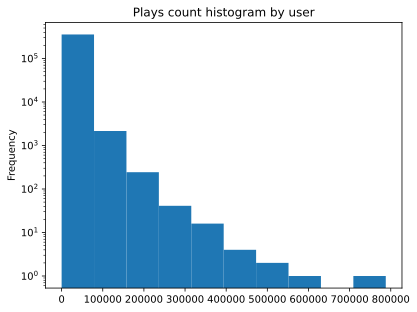

In [9]:
user_plays_df.groupby("user_id")["plays"].sum().plot.hist(title="Plays count histogram by user", xlabel="plays", ylabel="count", logy=True);

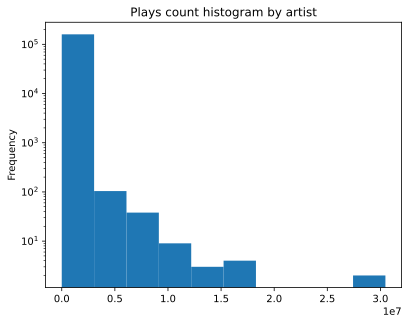

In [10]:
user_plays_df.groupby("artist_id")["plays"].sum().plot.hist(title="Plays count histogram by artist", xlabel="plays", ylabel="count", logy=True);

And also take a look at user features.

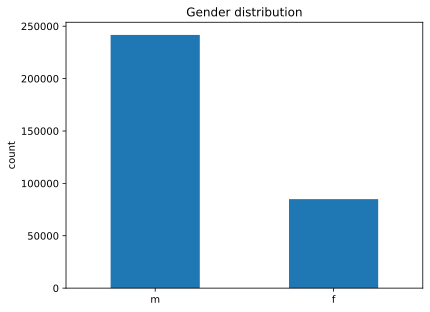

In [11]:
users["gender"].value_counts().plot.bar(title="Gender distribution", ylabel="count", rot=0);

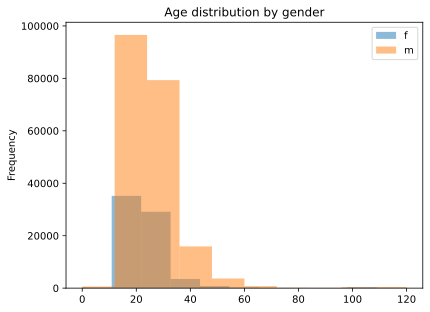

In [12]:
users["age"].clip(0, 120, inplace=True)
users.groupby("gender")["age"].plot.hist(title="Age distribution by gender", xlabel="age", ylabel="count", alpha=0.5, legend=True);

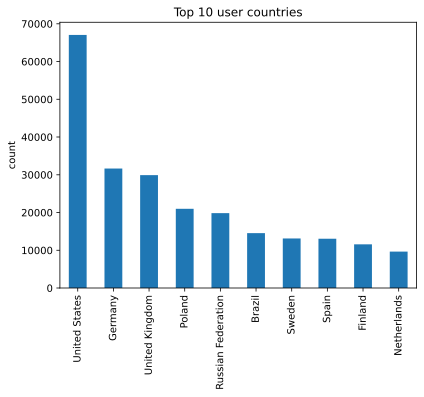

In [13]:
users["country"].value_counts().nlargest(10).plot.bar(title="Top 10 user countries", ylabel="count");

## Cleanup data

In [14]:
user_plays_df.isna().sum()

user_id             0
artist_id      226137
artist_name       204
plays               0
dtype: int64

In [28]:
user_plays_df = user_plays_df.dropna(subset=["artist_id", "artist_name"], how="all")

There are a lot of Null values in `artist_id`; we will map missing values through the column `artist_name`, as `artist_id` and `artist_name` are in a 1-to-1 relationship. We will fill in Null values there with generated UUIDs.

In [29]:
artist_name_to_id = user_plays_df[["artist_id", "artist_name"]].set_index("artist_name")

In [30]:
import uuid

def process_nan(x):
  return str(uuid.uuid4())

artist_name_to_id["artist_id"] = artist_name_to_id["artist_id"].apply(lambda x: process_nan(x) if x is np.nan else x)

In [33]:
artist_name_to_id

,artist_id
artist_name,
betty blowtorch,3bd73256-3905-4f3a-97e2-8b341527f805
die Ärzte,f2fb0ff0-5679-42ec-a55c-15109ce6e320
melissa etheridge,b3ae82c2-e60b-4551-a76d-6620f1b456aa
elvenking,3d6bbeb7-f90e-4d10-b440-e153c0d10b53
juliette & the licks,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8
...,...
turbostaat,7ffd711a-b34d-4739-8aab-25e045c246da
cuba missouri,9201190d-409f-426b-9339-9bd7492443e2
little man tate,e7cf7ff9-ed2f-4315-aca8-bcbd3b2bfa71


In [36]:
user_plays_df = user_plays_df.set_index("artist_name").fillna(artist_name_to_id).reset_index()

In [37]:
user_plays_df.isna().sum()

artist_name    202
user_id          0
artist_id        0
plays            0
dtype: int64

## Preprocess data

We don't need column `artist_name` for recsys model.

In [39]:
user_plays_df = user_plays_df.drop(["artist_name"], axis=1)
user_plays_df.head()

,user_id,artist_id,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,706


User features are located in `users` dataframe.

In [40]:
users.head()

,gender,age,country,signup
user_id,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
